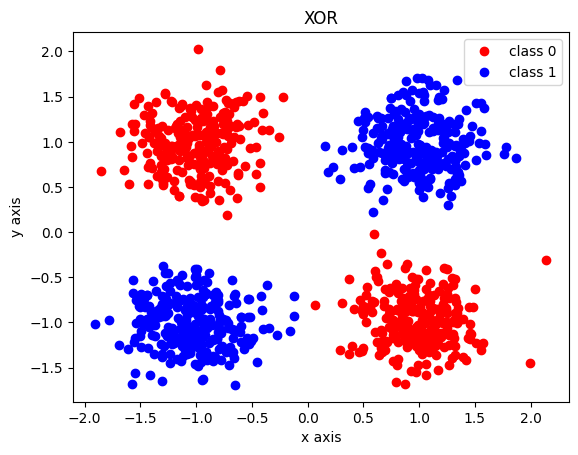

In [17]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

c0 = X[np.nonzero(Y)[0]]
c1 = X[np.nonzero(Y == 0)[0]]

plt.plot(c0[:,0], c0[:,1], 'ro', label='class 0')
plt.plot(c1[:,0], c1[:,1], 'bo', label='class 1')

plt.title('XOR') 
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.show()

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

training_data = DataLoader(TensorDataset(torch.Tensor(X[:750, :]), torch.tensor(
    Y[:750], dtype=torch.long)), shuffle=True, batch_size=batch_size)
validation_data = DataLoader(TensorDataset(torch.Tensor(
    X[750:, :]), torch.tensor(Y[750:], dtype=torch.long)), batch_size=batch_size)

In [19]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(2, 2)  # 2 inputs -> 2 hidden nodes
        self.output = nn.Linear(2, 2)  # 2 hidden nodes -> 2 outputs

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = self.output(x)
        return x


model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (hidden): Linear(in_features=2, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=2, bias=True)
)


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data, model, loss_fn, optimizer)
    test(validation_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.699354  [    0/  750]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.690882 

Epoch 2
-------------------------------
loss: 0.715241  [    0/  750]
Test Error: 
 Accuracy: 41.2%, Avg loss: 0.689954 

Epoch 3
-------------------------------
loss: 0.692563  [    0/  750]
Test Error: 
 Accuracy: 49.2%, Avg loss: 0.692812 

Epoch 4
-------------------------------
loss: 0.741954  [    0/  750]
Test Error: 
 Accuracy: 29.2%, Avg loss: 0.689511 

Epoch 5
-------------------------------
loss: 0.667988  [    0/  750]
Test Error: 
 Accuracy: 27.2%, Avg loss: 0.689239 

Epoch 6
-------------------------------
loss: 0.712745  [    0/  750]
Test Error: 
 Accuracy: 49.6%, Avg loss: 0.696651 

Epoch 7
-------------------------------
loss: 0.696987  [    0/  750]
Test Error: 
 Accuracy: 49.6%, Avg loss: 0.692391 

Epoch 8
-------------------------------
loss: 0.673268  [    0/  750]
Test Error: 
 Accuracy: 52.4%, Avg loss: 0.687939 

Epoch 9
----------------

In [24]:
def predict(x):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    #Predict and return ans
    ans = torch.argmax(model(x), dim=1)
    return ans.to('cpu').detach().numpy()

In [25]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title('XOR')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    # Plot ground truth
    c0 = X[np.nonzero(Y)[0]]
    c1 = X[np.nonzero(Y == 0)[0]]
    plt.plot(c0[:,0], c0[:,1], 'ko', label='class 0')
    plt.plot(c1[:,0], c1[:,1], 'wo', label='class 1')
    plt.legend()

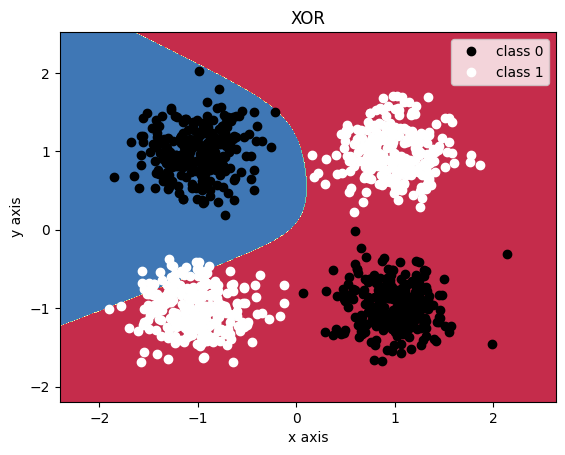

In [26]:
plot_decision_boundary(predict, X, Y)

In [27]:
def manual_xor(x):
    # Weights and biases for AND perceptron
    w_and = [1, 1]
    b_and = -1.5
    # Weights and biases for OR perceptron
    w_or = [1, 1]
    b_or = -0.5
    # Weights and biases for final perceptron
    w_final = [1, -1]
    b_final = -0.5

    def perceptron(weights, bias, inputs):
        z = np.dot(weights, inputs) + bias
        return 1 if z > 0 else 0

    # Compute AND and OR perceptrons
    and_out = perceptron(w_and, b_and, x)
    or_out = perceptron(w_or, b_or, x)

    # Compute final XOR output
    xor_out = perceptron(w_final, b_final, [or_out, and_out])
    return xor_out


# Test XOR manually
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([manual_xor(x) for x in inputs])
print("Manual XOR Outputs:", outputs)

Manual XOR Outputs: [0 1 1 0]
